# École Polytechnique de Montréal

Département Génie Informatique et Génie Logiciel
INF8460 – Traitement automatique de la langue naturelle

#### Prof. Amal Zouaq
#### Chargé de laboratoire: Félix Martel

# TP 3

## Objectifs

 - Implanter des modèles de classification neuronaux
 - Utiliser des plongements lexicaux pré-entrainés


## Travail à faire

Comme dans le TP précédent, on va travailler sur l'analyse de sentiment en utilisant les données du [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

Vous devez utiliser `scikit-learn` pour la régression logistique, et Keras pour les modèles neuronaux.

Les sections 1, 2 et 3 sont indépendantes.

Vous êtes libres d'appliquez les pré-traitements que vous jugerez utiles.

### 1. Pré-traitement et lecture de données

In [4]:
with open('test.txt', 'r') as mon_fichier:
    texte = mon_fichier.read()

print(texte)

Ceci est un test.



In [5]:
# Ici, vous devez lire vos données et appliquez les pré-traitements que vous jugerez utiles

# On fait comme dans le TP 2
import os

seq_train_neg = os.listdir("aclImdb/train/neg")
seq_train_pos = os.listdir("aclImdb/train/pos")

data_train_neg = [open("aclImdb/train/neg/" + file,  encoding="utf-8").read() for file in seq_train_neg]
data_train_pos = [open("aclImdb/train/pos/" + file,  encoding="utf-8").read() for file in seq_train_pos]
data_train = data_train_pos + data_train_neg



seq_test_neg = os.listdir("aclImdb/test/neg")
seq_test_pos = os.listdir("aclImdb/test/pos")

data_test_neg = [open("aclImdb/test/neg/" + file,  encoding="utf-8").read() for file in seq_test_neg]
data_test_pos = [open("aclImdb/test/pos/" + file,  encoding="utf-8").read() for file in seq_test_pos]
data_test = data_test_pos + data_test_neg

nb_doc_train = len(data_train)
nb_doc_test = len(data_test)

In [2]:
data_train_neg = data_train_neg[:1000]
data_train_pos = data_train_pos[:1000]
data_train = data_train_pos + data_train_neg
nb_doc_train = len(data_train)
nb_doc_test = len(data_test)
print(len(data_train))

2000


In [4]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import re




def segmentize(raw_text):
    """
    Segmente un document en phrases.

    >>> raw_corpus = "Alice est là . Bob est ici"
    >>> segmentize(raw_text)
    ["Alice est là .", "Bob est ici"]

    :param raw_text: str
    :return: list(str)
    """
    return nltk.sent_tokenize(raw_text)


def tokenize(sentences):
    """
    Tokenize une liste de phrases en mots.

    >>> sentences = ["Alice est là ", "Bob est ici"]
    >>> corpus = tokenize(sentences)
    >>> corpus_name
    [
        ["Alice", "est", "là "],
        ["Bob", "est", "ici"]
    ]

    :param sentences: list(str), une liste de phrases
    :return: list(list(str)), une liste de phrases tokenizées
    """
    res = []
    for sentence in sentences:
        res.append(nltk.word_tokenize(sentence))
    return res

def remove_stopwords(tokenized_text):
    """
    Remove the stopwords defined in nltk.corpus.stopwords from the given tokenized text.
    Nous devons enlever certains stopwords à la main.
    
    :param tokenized_text: list(list(str)), une liste de listes de tokens
    :return: list(list(str)), une liste de listes de tokens, sans les tokens correspondant aux stopwords
    """
    
    res = list()
    for sentence in tokenized_text:
        sentence_mod = list()
        for token in sentence:
             if token not in stopwords and token != "br" and token != "The" and token != "This":
                sentence_mod.append(token)
        res.append(sentence_mod)
    return res

def keep_only_alphabetic_characters(tokenized_text):
    """
    Remove non-alphabetic characters from the text
    
    :param tokenized_text: list(list(str)), une liste de liste de tokens
    :return: list(list(str)), une liste de listes de tokens sans caractère non-alphabétiques
    """

    res = list()
    for sentence in tokenized_text:
        sentence_mod = list()
        for token in sentence:
             if re.fullmatch("[a-zA-Z]*",token)!=None:
                sentence_mod.append(token)
        res.append(sentence_mod)
    return res

def remove_lone_characters(tokenized_text):
    """
    Remove one-character words from the text.
    
    :param tokenized_text: list(list(str)), une liste de liste de tokens
    :return: list(list(str)), une liste de listes de tokens sans caractères seuls
    """
    res = list()
    for sentence in tokenized_text:
        sentence_mod = list()
        for token in sentence:
             if len(token) > 1:
                sentence_mod.append(token)
        if sentence_mod != []:
            res.append(sentence_mod)
    return res

def clean_doc(corpus):
    tokens_preprocessed = []
    for documents in corpus:
        sentences = segmentize(documents)
        tokens = tokenize(sentences)
        tokens_stopword_free = remove_stopwords(tokens)
        tokens_alphabetic = keep_only_alphabetic_characters(tokens_stopword_free)
        tokens_preprocessed.append(remove_lone_characters(tokens_alphabetic))
    return (tokens_preprocessed)


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  Searched in:
    - 'C:\\Users\\mametc/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Anaconda3_64\\nltk_data'
    - 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Anaconda3_64\\share\\nltk_data'
    - 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Anaconda3_64\\lib\\nltk_data'
    - 'C:\\Users\\mametc\\AppData\\Roaming\\nltk_data'
**********************************************************************


Dans la suite, vous allez entraîner deux modèles neuronaux : un perceptron multi-couche (MLP pour *multi-layer perceptron*), un réseau récurrent LSTM bi-directionnel. Pour cela, vous devrez utiliser la librairie [Keras](https://keras.io/).

N'hésitez pas à expérimenter différents hyper-paramètres pour obtenir le meilleur résultat possible sur au moins un de vos réseaux(nombre de couches, dimension des couches, etc.). Quelques pistes:

- optimisation des hyper-paramètres avec validation croisée (tous modèles)

- réduction de la dimension avec une LSA (MLP)

- ajout de couches/augmentation de la dimension/dropout ou autres changements d'architecture (MLP ou LSTM)

- pré-traitement différent (tous modèles)


<mark>Il est **fortement conseillé** d'utiliser une machine avec GPU</mark> pour entraîner ces modèles neuronaux. Vous pouvez utiliser les machines du labo L-4818 ou faire tourner votre notebook sur [Google Colab](https://colab.research.google.com) (gratuit).

### 2. Multi-layer Perceptron

**a)** Ici, on vous demande d'entraîner un perceptron multi-couches sur la matrice TF-IDF. Avant l'entraînement, affichez la structure du modèle avec `model.summary()`. Précisez la structure du réseau de neurones (taille et nombre de couches) et les paramètres d'entraînement (optimiseur, nombre d'époques, etc.).

### 3. Bi-directional LSTM

**b)** Toujours avec Keras, entraînez un modèle bi-LSTM sur le corpus d'entraînement. Comme précédemment, affichez la structure du réseau et indiquez les paramètres utiles.

*Note :* si votre machine supporte CUDA, vous pouvez utiliser `keras.layers.CuDNNLSTM` au lieu de `keras.layers.LSTM` pour des gains de performance significatifs. Sur Google Colab, les environnements avec GPU supportent CUDA.

In [1]:
from keras.layers import LSTM

n_features = 10
sequence_len = 50
lstm_model = Sequential([
                        LSTM(64, input_shape=(sequence_len, n_features),
                        Dense(1, activation="softmax")])

SyntaxError: invalid syntax (<ipython-input-1-26404f036877>, line 7)

In [2]:
from keras.layers import LSTM

Using TensorFlow backend.


In [15]:
!pip install tensoflow
!pip install keras

  Could not find a version that satisfies the requirement tensoflow (from versions: )
No matching distribution found for tensoflow
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl


distributed 1.21.8 requires msgpack, which is not installed.
Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Anaconda3_64\\Lib\\site-packages\\keras_preprocessing'
Consider using the `--user` option or check the permissions.

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [7]:
X_train = list(map(lambda p: clean_text(p), data_train))

In [8]:
print(X_train[0])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life , such as "teachers" . my 35 years in the teaching profession lead me to believe that bromwell high is satire is much closer to reality than is "teachers" . the scramble to survive financially , the insightful students who can see right through their pathetic teachers' pomp , the pettiness of the whole situation , all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school , i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line: inspector: i am here to sack one of your teachers . student: welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it is not !


max phrase len: 1978


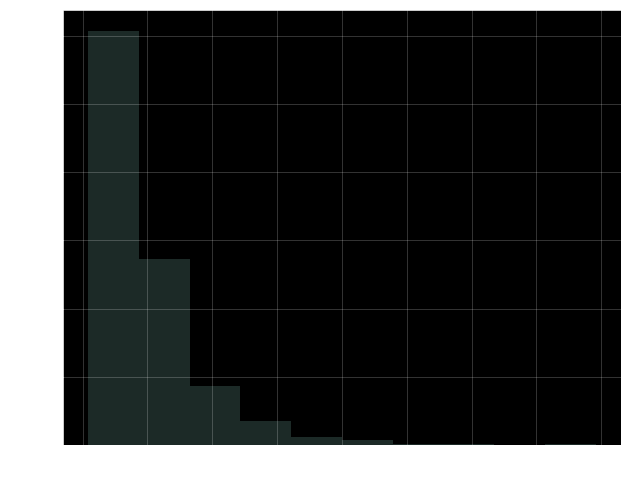

In [9]:
phrase_len = list(map(lambda p: len(p.split(' ')), X_train))
max_phrase_len = max(phrase_len)
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [10]:
y_train = [1 for i in range(len(data_train_pos))] + [0 for i in range(len(data_train_neg))]

In [11]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [29]:
batch_size = 512
epochs = 1

In [30]:
print(max_phrase_len, max_words)

1978 8192


In [33]:
lstm = Sequential()
lstm.add(LSTM(64, input_shape = (len(data_train), max_phrase_len)))
lstm.add(Dense(1, activation = "sigmoid"))

lstm.summary()

lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                523008    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 523,073
Trainable params: 523,073
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 64
)

ValueError: Error when checking input: expected lstm_11_input to have 3 dimensions, but got array with shape (2000, 1978)

In [14]:
model_lstm = Sequential()
#model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
#model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
#model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(2, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, dropout=0.3, recurrent_dropout=0.3, input_shape=(1978, 819..., units=256)`
  after removing the cwd from sys.path.


TypeError: __init__() got multiple values for argument 'units'

In [13]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

ValueError: Input 0 is incompatible with layer lstm_1: expected ndim=3, found ndim=2

**c) Word Embeddings**

Pour améliorer le modèle précédent, on va utiliser des *word embeddings* (ou plongements vectoriels) pré-entraînés. 

On utilisera un modèle Skip-gram de dimension $d=300$ entraîné sur English Wikipedia, disponible à l'adresse [http://vectors.nlpl.eu/explore/embeddings/en/models/](http://vectors.nlpl.eu/explore/embeddings/en/models/). Dans cette archive, vous trouverez les embeddings dans un fichier `.txt` tel que 
- la première ligne du fichier indique le nombre de mots dans le vocabulaire et la dimension des embeddings
- chacune des lignes suivantes est composée d'un mot_étiquette grammaticale suivi des 300 coordonnées de son *embedding*, le tout séparé par des espaces. 

Ainsi, les premières lignes de ce fichier sont :
```
296630 300
also_ADV -0.010121 -0.045202 -0.065609 ... -0.065423
one_NUM -0.060427 0.005032 -0.076370 ... -0.107769
first_ADJ 0.005799 0.024848 0.018902 ...  -0.097193
...
```

Les étiquettes `_ADV`, `_NUM`, `_ADJ`, etc. indiquent l'étiquette grammaticale du mot et peuvent être supprimées pour ce TP.

*Note :* vous pouvez utiliser le snippet suivant pour télécharger et dézipper automatiquement les embeddings (pratique si vous utilisez une machine distante comme Google Colab) :
```python
import requests
import io
from zipfile import ZipFile

res = requests.get("http://link/to/archive.zip")
with ZipFile(io.BytesIO(res.content)) as z:
  z.extractall("extract/to/dir/")
```


Implémentez un modèle bi-LSTM qui utilisent ces *embeddings* pour représenter les mots d'une phrase. Vous pourrez utiliser le layer [Embedding](https://keras.io/layers/embeddings/) de Keras.

### 5. Évaluation

**d)** Indiquez les performances de chacun de vos modèles. Comparez avec les modèles Naive Bayes et character-LM du TP précédent et commentez.

Quel est votre meilleur modèle ?